# Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2
import sys
import keras
import tensorflow as tf

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications import DenseNet121
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

In [2]:
print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"OpenCV version: {cv2.__version__}")

print(f"GPU is available: {tf.test.is_gpu_available()}")

Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.14.0
Keras version: 2.14.0
OpenCV version: 4.8.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available: False


## Declare constants that will be used later

In [3]:
EPOCHS = 50
INIT_LR = 1e-3 # 1E-3
BS = 32
width=128
height=128
default_image_size = tuple((height,width))
image_size = 0
directory_root = 'C:/Users/Mean Machine/Desktop/PlantVillage'
depth=3

# Data preprocessing

## Function to convert image to numpy array

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

## Function to load images from the directory

In [5]:
def load_image_from_dir(start=0, end=500, image_list=[], label_list=[]):
    try:
        print("Loading images ...")
        root_dir = listdir(directory_root)
        for directory in root_dir :
            # remove .DS_Store from list
            if directory == ".DS_Store" :
                root_dir.remove(directory)

        for plant_folder in root_dir:
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

            for disease_folder in plant_disease_folder_list :
                # remove .DS_Store from list
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"\t*Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")

                for single_plant_disease_image in plant_disease_image_list :
                    if single_plant_disease_image == ".DS_Store" :
                        plant_disease_image_list.remove(single_plant_disease_image)
                if start > len(plant_disease_image_list):
                    for image in plant_disease_image_list[0:100]:
                        image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                            image_list.append(convert_image_to_array(image_directory))
                            label_list.append(plant_disease_folder)
                else:
                    for image in plant_disease_image_list[start:end]:
                        image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                            image_list.append(convert_image_to_array(image_directory))
                            label_list.append(plant_disease_folder)
        print("Image loading completed")  
    except Exception as e:
        print(f"Error : {e}")
    finally:
        return image_list, label_list

## Loading the images and simultenously coverting them

In [6]:
image_list, label_list = [], []
image_list, label_list = load_image_from_dir(
    start=0, 
    end=600, 
    image_list=image_list, 
    label_list=label_list
)

Loading images ...
	*Processing Apple___Apple_scab ...
	*Processing Apple___Black_rot ...
	*Processing Apple___Cedar_apple_rust ...
	*Processing Apple___healthy ...
	*Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
	*Processing Corn_(maize)___Common_rust_ ...
	*Processing Corn_(maize)___healthy ...
	*Processing Corn_(maize)___Northern_Leaf_Blight ...
	*Processing Grape___Black_rot ...
	*Processing Grape___Esca_(Black_Measles) ...
	*Processing Grape___healthy ...
	*Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
	*Processing Potato___Early_blight ...
	*Processing Potato___healthy ...
	*Processing Potato___Late_blight ...
	*Processing Tomato___Bacterial_spot ...
	*Processing Tomato___Early_blight ...
	*Processing Tomato___healthy ...
	*Processing Tomato___Late_blight ...
	*Processing Tomato___Leaf_Mold ...
	*Processing Tomato___Septoria_leaf_spot ...
	*Processing Tomato___Spider_mites Two-spotted_spider_mite ...
	*Processing Tomato___Target_Spot ...
	*Processi

In [7]:
# Get size of processed image
image_size = len(image_list)
print(image_size)

26588


## Generating categories of images

In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


## Normalizing the pixel values

In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

## Splitting the data into Train and Validation sets

In [10]:
print("Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(
    np_image_list, 
    image_labels, 
    test_size=0.2, 
    random_state=42
#     stratify=image_labels
) 

Spliting data to train, test


In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21270, 128, 128, 3), (21270, 25), (5318, 128, 128, 3), (5318, 25))

# Preparing the model for training

## Creating an instance of Image Augmentor

In [12]:
aug = ImageDataGenerator(
    rotation_range=45,          # Randomly rotates images in range [-45, 45] degrees
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"         # fill newly created missing pixels during the image transformation
)

## Defining the model

In [13]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = keras.Input(shape=(height, width, depth))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(25,activation = 'softmax', name='root')(x)

    model = Model(input,output)
    
    optimizer = Adam(
        learning_rate=INIT_LR, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=0.1, 
        weight_decay=INIT_LR / EPOCHS
    )
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

## Creating the model and checkpoint

In [14]:
model = build_densenet()
annealer = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=5, 
    verbose=1, 
    min_lr=1e-3
)
checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss',
    verbose=1,
    save_best_only=True, 
    mode='auto')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                             

## Training the model

In [15]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=10, 
    verbose=1,
    callbacks=[checkpoint]
)

C:\Users\Mean Machine\AppData\Local\Temp\ipykernel_16628\2711058095.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
664/664 [==============================] - ETA: 0s - loss: 1.8427 - accuracy: 0.5111
Epoch 1: val_loss improved from inf to 0.35737, saving model to best_model.h5


C:\Users\Mean Machine\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 2070s 3s/step - loss: 1.8427 - accuracy: 0.5111 - val_loss: 0.3574 - val_accuracy: 0.8836
Epoch 2/10
664/664 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.8456
Epoch 2: val_loss did not improve from 0.35737
664/664 [==============================] - 2136s 3s/step - loss: 0.4914 - accuracy: 0.8456 - val_loss: 0.3737 - val_accuracy: 0.8812
Epoch 3/10
664/664 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.9082
Epoch 3: val_loss improved from 0.35737 to 0.25056, saving model to best_model.h5
664/664 [==============================] - 2138s 3s/step - loss: 0.2953 - accuracy: 0.9082 - val_loss: 0.2506 - val_accuracy: 0.9225
Epoch 4/10
664/664 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9313
Epoch 4: val_loss did not improve from 0.25056
664/664 [==============================] - 2152s 3s/step - loss: 0.2230 - accuracy: 0.9313 - val_loss: 0.4086 - val_accuracy: 0.8783
Epoc

## Plot the training performance graph

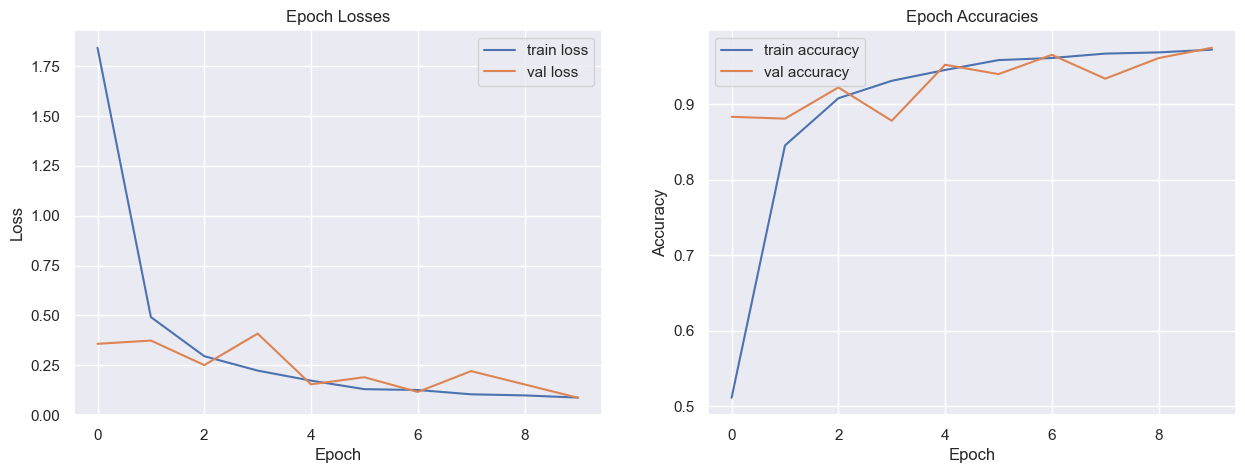

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history.history['loss'], label='train loss')
axes[0].plot(history.history['val_loss'], label='val loss')
axes[0].set_title('Epoch Losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='train accuracy')
axes[1].plot(history.history['val_accuracy'], label='val accuracy')
axes[1].set_title('Epoch Accuracies')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

# Testing the model on unseen data

## Check the best saved model's Validation set accuracy

In [24]:
# model_path = '/kaggle/input/densenet121-finetuned-plantvillage/model_dnet121.h5'
# test_model = keras.models.load_model(model_path)

test_model = keras.models.load_model('best_model.h5')
scores = test_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

167/167 [==============================] - 98s 564ms/step - loss: 0.0868 - accuracy: 0.9752
Test Accuracy: 97.51786589622498


## Function to load test data

In [142]:
def load_test_image_from_dir(start=0, end=500, image_list=[], label_list=[]):
    try:
        print("Loading images ...")
        root_dir = listdir(directory_root)
        for directory in root_dir :
            # remove .DS_Store from list
            if directory == ".DS_Store" :
                root_dir.remove(directory)

        for plant_folder in root_dir :
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

            for disease_folder in plant_disease_folder_list :
                # remove .DS_Store from list
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"\t*Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")

                for single_plant_disease_image in plant_disease_image_list :
                    if single_plant_disease_image == ".DS_Store" :
                        plant_disease_image_list.remove(single_plant_disease_image)
                if start > len(plant_disease_image_list):
                    for image in plant_disease_image_list[0:100]:
                        image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                            image_list.append(image_directory)
                            label_list.append(plant_disease_folder)
                else:
                    for image in plant_disease_image_list[start:end]:
                        image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                            image_list.append(image_directory)
                            label_list.append(plant_disease_folder)
        print("Image loading completed")  
    except Exception as e:
        print(f"Error : {e}")
    finally:
        return image_list, label_list

In [137]:
load_test_image_from_dir()

Loading images ...
Image loading completed


([array([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255

## Loading the test data

In [143]:
test_image_list, test_label_list = [], []
test_image_list, test_label_list = load_test_image_from_dir(
     start=600, 
     end=700, 
    image_list=test_image_list, 
    label_list=test_label_list
)

Loading images ...
	*Processing Apple___Apple_scab ...
	*Processing Apple___Black_rot ...
	*Processing Apple___Cedar_apple_rust ...
	*Processing Apple___healthy ...
	*Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
	*Processing Corn_(maize)___Common_rust_ ...
	*Processing Corn_(maize)___healthy ...
	*Processing Corn_(maize)___Northern_Leaf_Blight ...
	*Processing Grape___Black_rot ...
	*Processing Grape___Esca_(Black_Measles) ...
	*Processing Grape___healthy ...
	*Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
	*Processing Potato___Early_blight ...
	*Processing Potato___healthy ...
	*Processing Potato___Late_blight ...
	*Processing Tomato___Bacterial_spot ...
	*Processing Tomato___Early_blight ...
	*Processing Tomato___healthy ...
	*Processing Tomato___Late_blight ...
	*Processing Tomato___Leaf_Mold ...
	*Processing Tomato___Septoria_leaf_spot ...
	*Processing Tomato___Spider_mites Two-spotted_spider_mite ...
	*Processing Tomato___Target_Spot ...
	*Processi

## Prepareing test data for prediction

In [155]:
CATEGORIES = [
'Apple___Apple_scab',
'Apple___Black_rot',
'Apple___Cedar_apple_rust',
'Apple___healthy',
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
'Corn_(maize)___Common_rust_',
'Corn_(maize)___healthy',
'Corn_(maize)___Northern_Leaf_Blight',
'Grape___Black_rot',
'Grape___Esca_(Black_Measles)',
'Grape___healthy',
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
'Potato___Early_blight',
'Potato___healthy',
'Potato___Late_blight',
'Tomato___Bacterial_spot',
'Tomato___Early_blight',
'Tomato___healthy',
'Tomato___Late_blight',
'Tomato___Leaf_Mold',
'Tomato___Septoria_leaf_spot',
'Tomato___Spider_mites Two-spotted_spider_mite',
'Tomato___Target_Spot',
'Tomato___Tomato_mosaic_virus',
'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
'Apple___Apple_scab',
'Apple___Black_rot',
'Apple___Cedar_apple_rust',
'Apple___healthy',
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
'Corn_(maize)___Common_rust_',
'Corn_(maize)___healthy',
'Corn_(maize)___Northern_Leaf_Blight',
'Grape___Black_rot',
'Grape___Esca_(Black_Measles)',
'Grape___healthy',
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
'Potato___Early_blight',
'Potato___healthy',
'Potato___Late_blight',
'Tomato___Bacterial_spot',
'Tomato___Early_blight',
'Tomato___healthy',
'Tomato___Late_blight',
'Tomato___Leaf_Mold',
'Tomato___Septoria_leaf_spot',
'Tomato___Spider_mites Two-spotted_spider_mite',
'Tomato___Target_Spot',
'Tomato___Tomato_mosaic_virus',
'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]


def image_to_array(path):
    img = cv2.imread(path)
    new_arr = cv2.resize(img,(128, 128))
    new_arr = np.array(new_arr/255)
    new_arr = new_arr.reshape(-1, 128, 128, 3)
    return new_arr

In [156]:
id2label = {key: val for key, val in enumerate(label_binarizer.classes_.tolist())}
label2id = {val: key for key, val in id2label.items()}

## Predict labels for test data

In [157]:
actual = []
predicted = []

for i in range(len(test_image_list)):
    image = image_to_array(test_image_list[i])
    prediction = test_model.predict(image, verbose=0)

    actual.append(test_label_list[i])
    predicted.append(CATEGORIES[prediction.argmax()])

## Generate confusion matrix of predictions

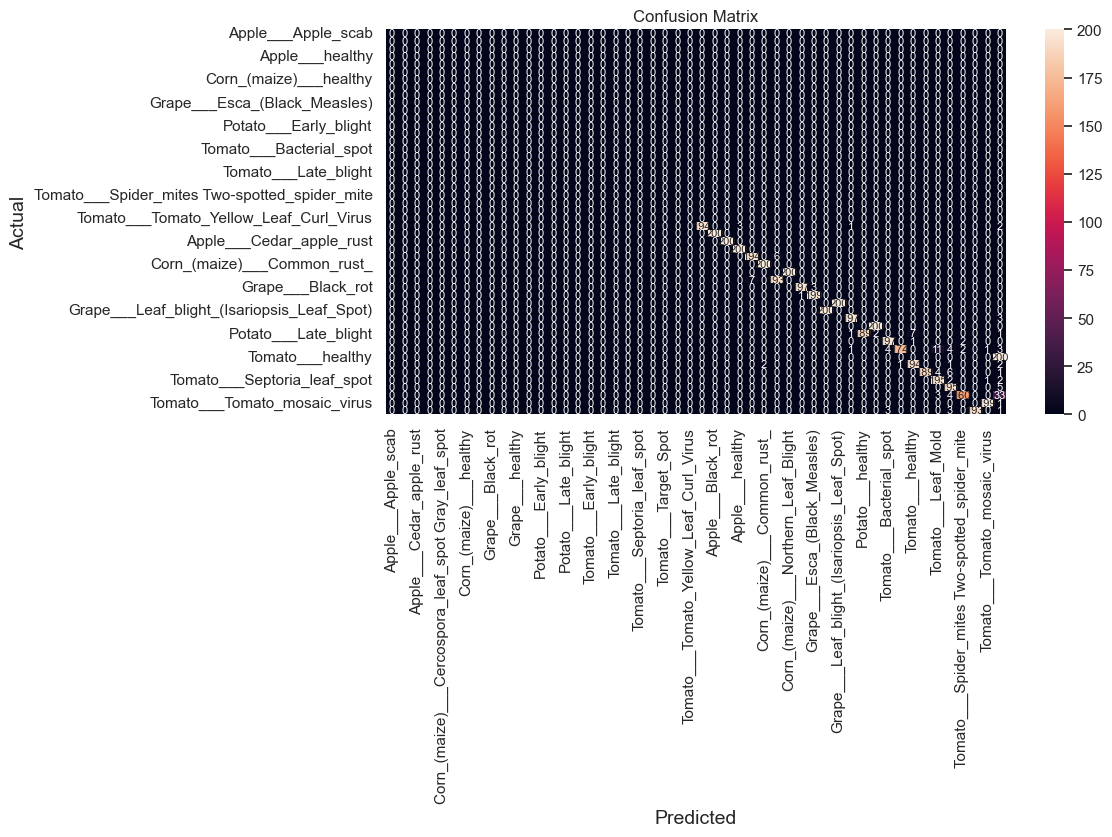

In [158]:
cm = confusion_matrix(actual, predicted, labels=CATEGORIES)
cm_df = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)

plt.figure(figsize = (10,5))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 8}, fmt="")
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontdict={'size': 14})
plt.ylabel('Actual', fontdict={'size': 14})
plt.show()

## Generate classification report

In [159]:
from sklearn.metrics import classification_report

report = classification_report(actual, predicted)

print(f'Classification report: \n{report}')

Classification report: 
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.97      0.98       200
                                 Apple___Black_rot       1.00      1.00      1.00       200
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       200
                                   Apple___healthy       0.99      1.00      0.99       200
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.97      0.97       200
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       200
               Corn_(maize)___Northern_Leaf_Blight       0.00      0.00      0.00       200
                            Corn_(maize)___healthy       0.00      0.00      0.00       200
                                 Grape___Black_rot       0.99      0.98      0.99       200
                      Grape___Esca_(Black_Measles)     